In [1]:
import scipy.io
import matplotlib.pyplot as plt

data = scipy.io.loadmat('Brain.mat')

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])

In [2]:
mri_stacked = data['T1']
mri_labels = data['label']

print(mri_stacked.shape)
print(mri_labels.shape)

(362, 434, 10)
(362, 434, 10)


In [3]:
# Max and min label
label_names = ['air', 'skin/scalp', 'skull', 'CSF', 'Gray Matter', 'White Matter']
print(mri_labels[:,:,0].max())
print(mri_labels[:,:,0].min())

5
0


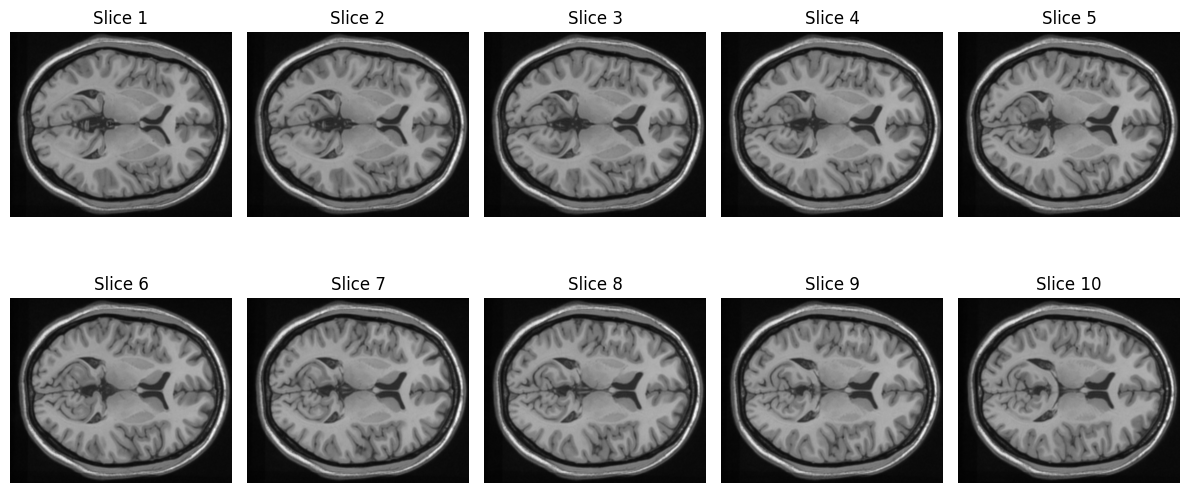

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_stacked[:, :, i], cmap='gray')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

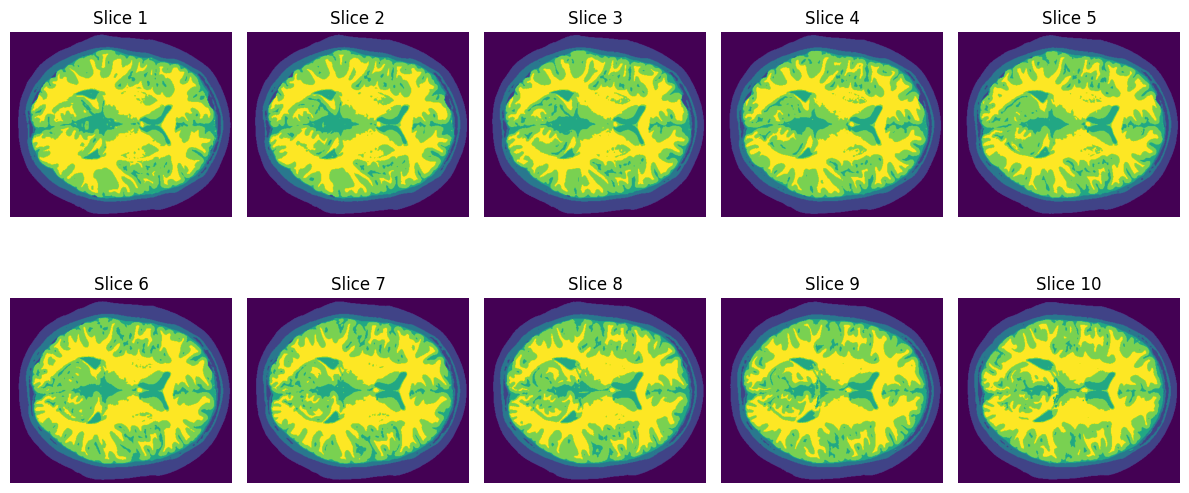

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_labels[:, :, i])
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

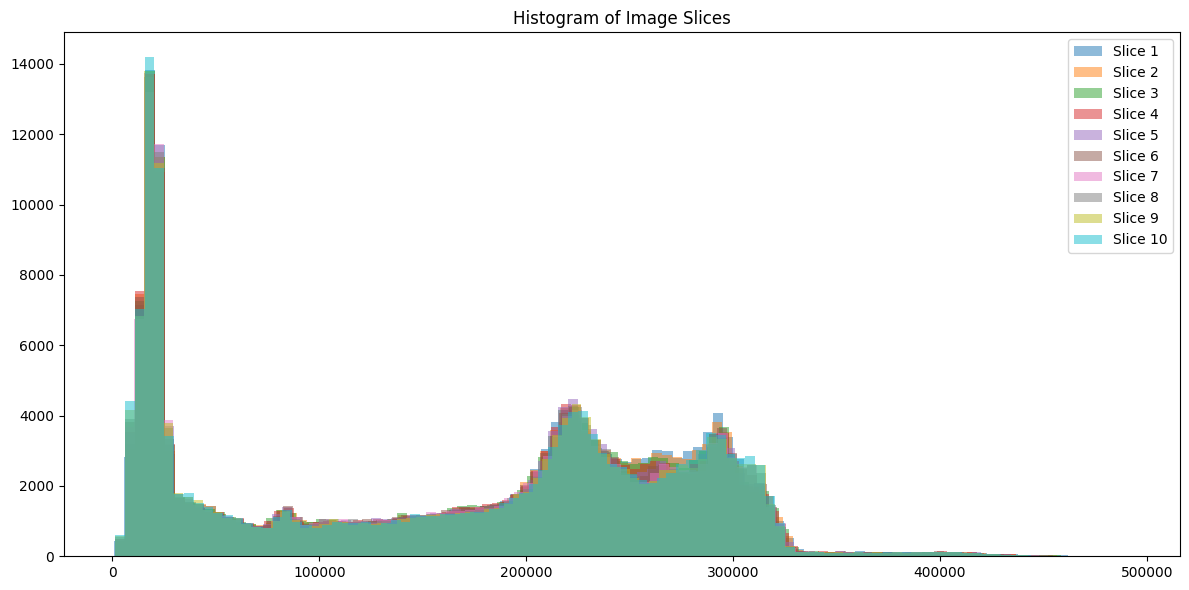

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(mri_stacked.shape[2]):
    hist = plt.hist(mri_stacked[:, :, i].flatten(), bins=100, alpha=0.5, label=f'Slice {i+1}')

ax.set_title('Histogram of Image Slices')
ax.legend()

plt.tight_layout()
plt.show()


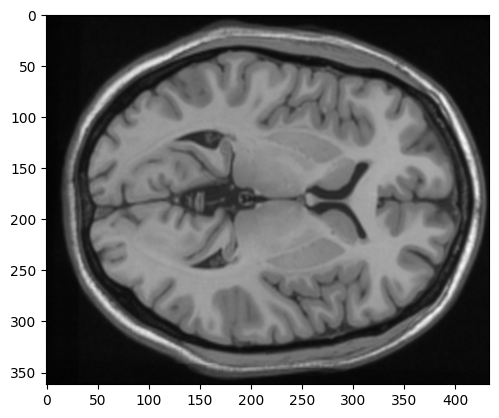

In [7]:
reference_img = mri_stacked[:,:,0]
plt.imshow(reference_img, cmap='gray')

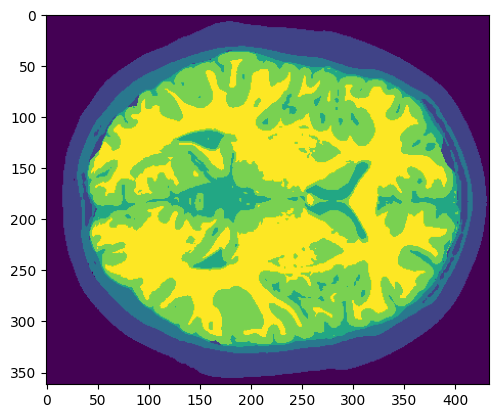

In [8]:
reference_labels = mri_labels[:,:,0]
plt.imshow(reference_labels)

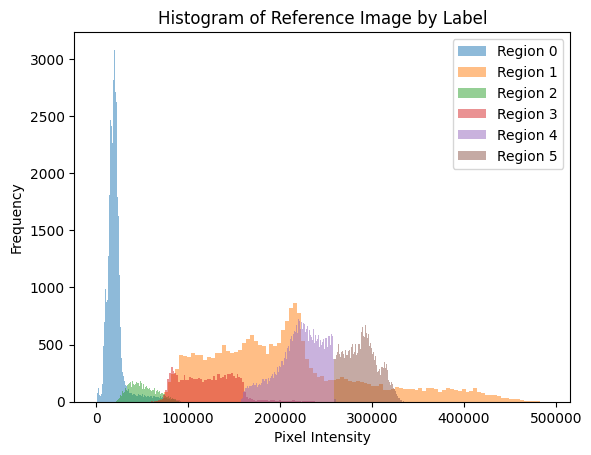

In [15]:
import numpy as np

# Flatten the reference_labels
labels_flat = reference_labels

# Initialize an empty list to store the histograms
histograms = []

# Iterate over unique labels
for label in np.unique(labels_flat):
    # Select the pixels with the current label
    pixels = reference_img[labels_flat == label]
    
    # Plot the histogram of the selected pixels
    hist = plt.hist(pixels.flatten(), bins=100, alpha=0.5, label=f'Region {label}')
    
    # Append the histogram to the list
    histograms.append(hist)

# Show the legend
plt.legend()

# Set the title and labels
plt.title('Histogram of Reference Image by Label')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [26]:
label_names

['air', 'skin/scalp', 'skull', 'CSF', 'Gray Matter', 'White Matter']

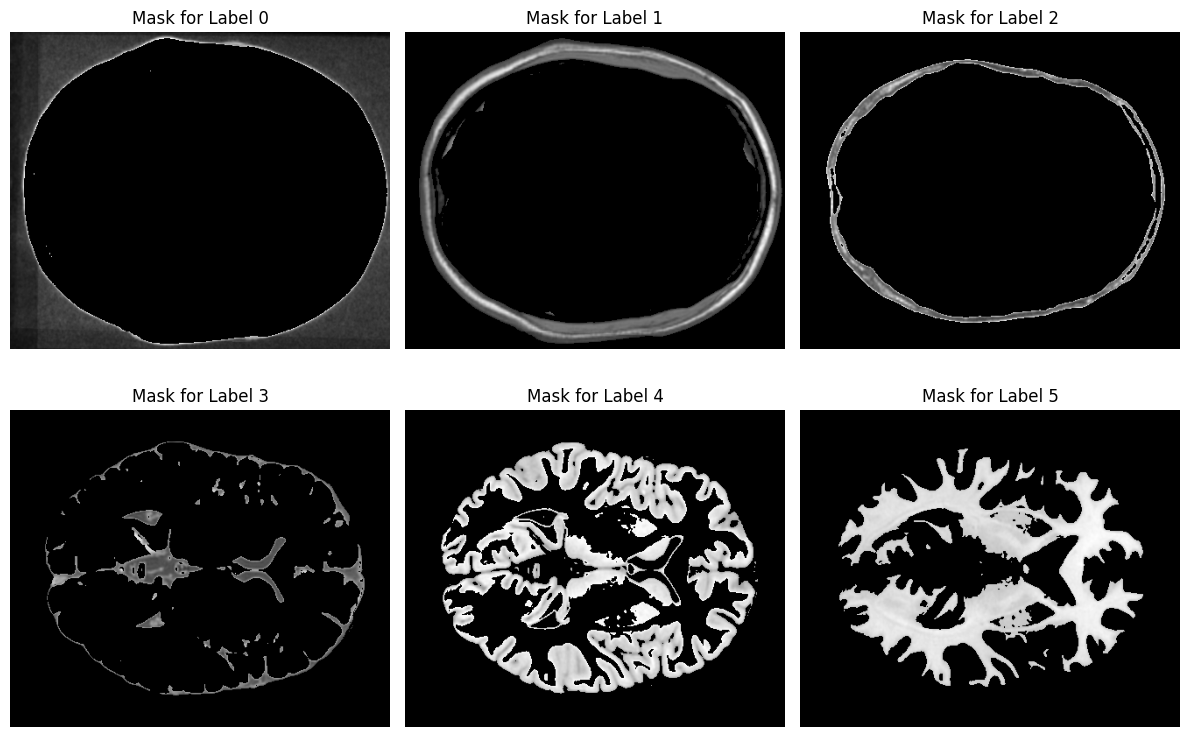

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    mask = reference_img * (reference_labels == i)
    ax.imshow(mask.reshape(reference_img.shape), cmap='gray')
    ax.set_title(f'Mask for Label {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


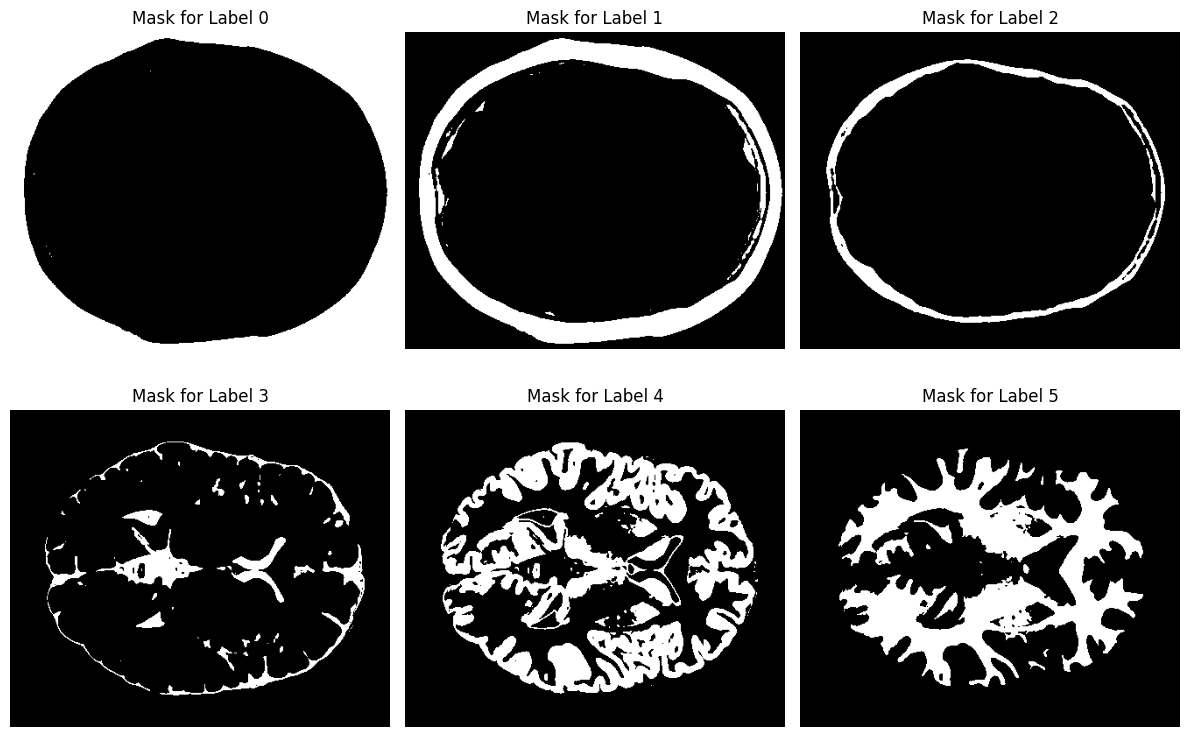

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(reference_labels == i, cmap='gray')
    ax.set_title(f'Mask for Label {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


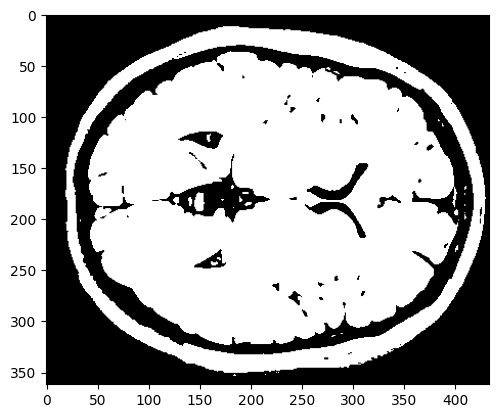

In [28]:
# Segmenting the reference image

# Apply an outsu algorithm to the reference image
from skimage.filters import threshold_otsu
threshold = threshold_otsu(reference_img)
binary = reference_img > threshold

# Plot the binary image
plt.imshow(binary, cmap='gray')

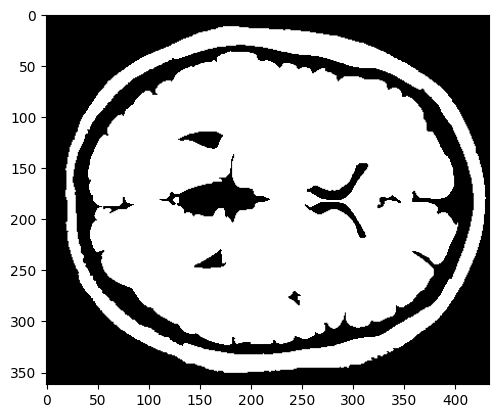

In [37]:
# Remove the smaller artifict within each white or black region
from skimage.morphology import remove_small_objects, remove_small_holes

cleaned = remove_small_holes(binary)
cleaned = remove_small_objects(cleaned, min_size=1000)

# Plot the cleaned image
plt.imshow(cleaned, cmap='gray')

- [TODO] Possible way to smooth the contours

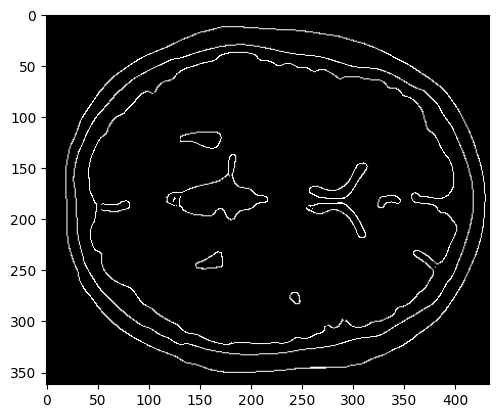

In [50]:
# Get edges with canny
from skimage.feature import canny
edges = canny(cleaned, sigma=3)

# Plot the edges
plt.imshow(edges, cmap='gray')

/home/zosov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `selem` is a deprecated argument name for `binary_erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  """
/home/zosov/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  


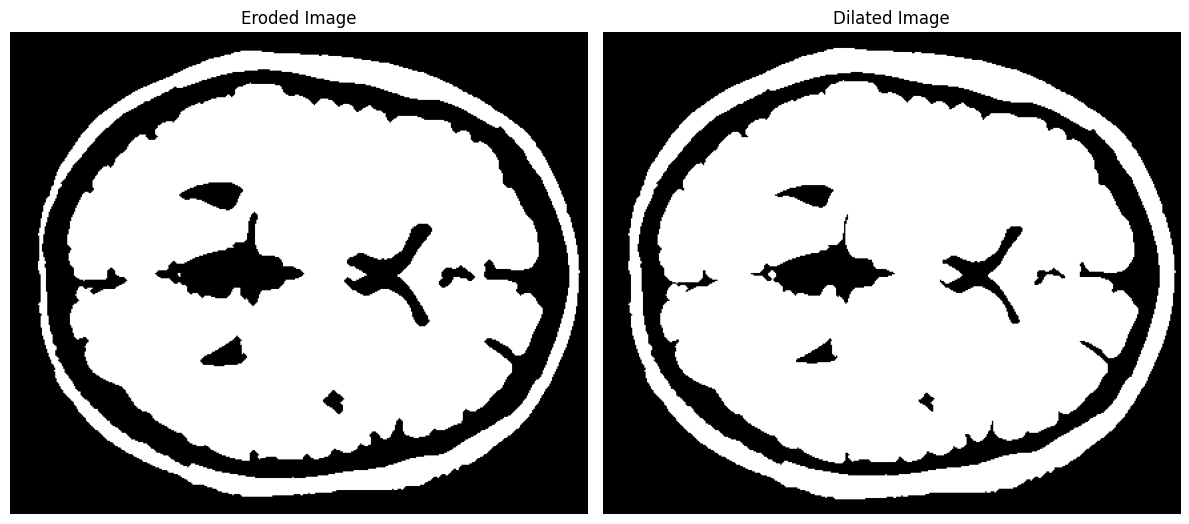

In [48]:
# # smooth the countours of the binary image
# from skimage.morphology import binary_erosion, binary_dilation
# from skimage.morphology import disk

# eroded = binary_erosion(cleaned, selem=disk(2))
# dilated = binary_dilation(eroded, selem=disk(2))

# # Plot the eroded and dilated images
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# axes[0].imshow(eroded, cmap='gray')
# axes[0].set_title('Eroded Image')
# axes[0].axis('off')

# axes[1].imshow(dilated, cmap='gray')
# axes[1].set_title('Dilated Image')
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()

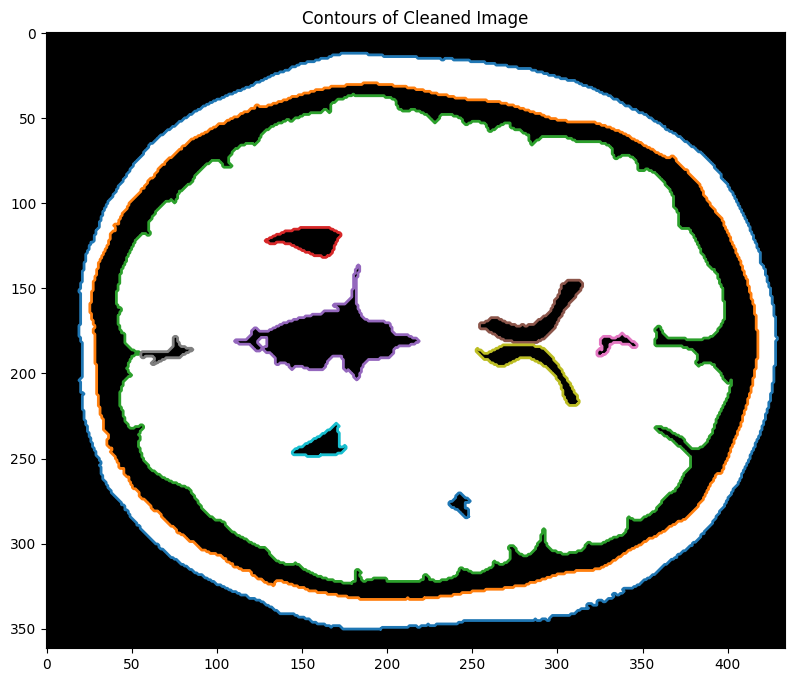

In [44]:
# get the countour of the cleaned image
from skimage.measure import find_contours
contours = find_contours(cleaned, 0.8)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(cleaned, cmap='gray')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.title('Contours of Cleaned Image')
plt.show()


In [56]:
import cv2
import numpy as np

# Assuming 'contours' is a list of contours you have found
# and 'img' is your original image

# Create a blank image with the same size as the original image
mask = np.zeros_like(cleaned, dtype=np.uint8)

# Draw the contours on the blank image. The arguments are:
# - the destination image
# - the contours
# - the contour index (negative to draw all contours)
# - the color (white)
# - the thickness (negative to fill the contour)
cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

# Convert the 8-bit mask to a boolean mask
mask = mask.astype(bool)

# Now 'mask' is a boolean image where the area inside the contours is True
# and the area outside the contours is False

# Plot the mask
plt.imshow(mask, cmap='gray')


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/drawing.cpp:2538: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'
